### Comparaison des performances d'un ResNet 34, d'un Xception et d'un Vision Transformer pour classifier les donnees de Fashion MNIST, CIFAR-10 et CIFAR-100

In [1]:
# Python ≥ 3.8 is required
import sys
assert sys.version_info >= (3,8)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import pandas as pd
from IPython.display import Image
%matplotlib inline

# Scikit-Learn ≥ 0.23 is required
import sklearn
assert sklearn.__version__ >= "0.23"

# TensorFlow ≥ 2.4 and Keras ≥ 2.4 is required
import tensorflow as tf
from tensorflow import keras
#import tensorflow_addons as tfa
assert tf.__version__ >= "2.4"
assert keras.__version__ >= "2.4"

print("The version of your Tensorflow is "+ tf.__version__)
print("The version of your Keras is "+ keras.__version__)

The version of your Tensorflow is 2.4.1
The version of your Keras is 2.4.0


In [2]:
# Enable memory growth

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
# Number of GPU used

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices("GPU")))

Num GPUs Available:  1


# Loading the dataset

In [4]:
# Loading and scaling Fashion MNIST dataset

fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test_fm, y_test_fm) = fashion_mnist.load_data()

X_valid_fm, X_train_fm = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid_fm, y_train_fm = y_train_full[:5000], y_train_full[5000:]
X_test_fm = X_test_fm / 255.

# Reshaping data into (batch size, height, weight, channel)

X_train_fm = X_train_fm.reshape(-1,28,28,1)
X_valid_fm = X_valid_fm.reshape(-1,28,28,1)
X_test_fm = X_test_fm.reshape(-1,28,28,1)

In [5]:
# Loading and scaling CIFAR-10 dataset

cifar10 = keras.datasets.cifar10
(X_train_full, y_train_full), (X_test_c10, y_test_c10) = cifar10.load_data()

X_valid_c10, X_train_c10 = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid_c10, y_train_c10 = y_train_full[:5000], y_train_full[5000:]
X_test_c10 = X_test_c10 / 255.

In [6]:
X_train_c10.shape

(45000, 32, 32, 3)

In [7]:
# Loading and scaling the CIFAR-100 dataset

cifar100 = keras.datasets.cifar100
(X_train_full, y_train_full), (X_test_c100, y_test_c100) = cifar100.load_data()

X_valid_c100, X_train_c100 = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid_c100, y_train_c100 = y_train_full[:5000], y_train_full[5000:]
X_test_c100 = X_test_c100 / 255.

In [8]:
X_train_c100.shape

(45000, 32, 32, 3)

# Implementing ResNet 34 from scratch
### 34 layers (only counting the convolutional layers and the fully connected layer) containing 3 residual units that output 64 feature maps, 4 residual units with 128 maps, 6 residual units with 256 maps, and 3 residual units with 512 maps.

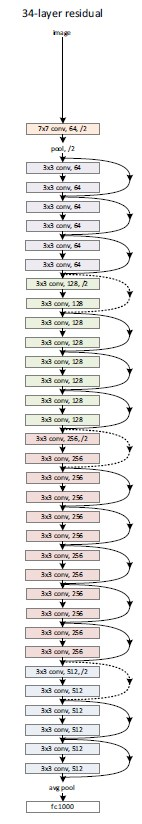

In [9]:
Image(filename='ResNet.jpg')

In [10]:
# DefaultConv2D is a small line of code to avoid writing everytime "keras.layers.Conv2D()" for adding layers
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
            
        return self.activation(Z + skip_Z)

In [11]:
# Build a ResNet-34 using a Sequential model: we will use the ResidualUnit class we've just created

def resnet(data, num_classes):
    
    np.random.seed(5)
    tf.random.set_seed(5)
    
    ResNet_model = keras.models.Sequential()
    ResNet_model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                            input_shape=data.shape[1:]))
    ResNet_model.add(keras.layers.BatchNormalization())
    ResNet_model.add(keras.layers.Activation("relu"))
    ResNet_model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
    prev_filters = 64
    # 3 RUs with 64 filters, following 4 RUs with 128 filters, 6 RUs with 256 filters and 3 RUs with 512 filters
    for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
        strides = 1 if filters == prev_filters else 2
        ResNet_model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters
    ResNet_model.add(keras.layers.GlobalAvgPool2D())
    ResNet_model.add(keras.layers.Flatten())
    ResNet_model.add(keras.layers.Dense(num_classes, activation="softmax"))
    
    return ResNet_model

##### Fitting ResNet Model on Fashion MNIST

In [12]:
res_model = resnet(X_train_fm, 10)
res_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        3136      
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 7, 7, 64)          74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 7, 7, 64)          74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 7, 7, 64)          7

In [13]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)
res_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [14]:
# Fitting the model

start = time.time()
resnet_fm = res_model.fit(X_train_fm, y_train_fm, epochs=10, validation_data=(X_valid_fm, y_valid_fm),
                                 batch_size = 128)
end = time.time()
print("Temps total d'execution = "+str(end-start) +" "+ "s")

Epoch 1/10
430/430 [==============================] - 39s 72ms/step - loss: 0.7192 - accuracy: 0.7636 - val_loss: 0.9143 - val_accuracy: 0.6574
Epoch 2/10
430/430 [==============================] - 29s 67ms/step - loss: 0.3274 - accuracy: 0.8795 - val_loss: 0.3965 - val_accuracy: 0.8578
Epoch 3/10
430/430 [==============================] - 29s 68ms/step - loss: 0.2800 - accuracy: 0.8959 - val_loss: 0.3383 - val_accuracy: 0.8774
Epoch 4/10
430/430 [==============================] - 29s 67ms/step - loss: 0.2547 - accuracy: 0.9061 - val_loss: 0.3478 - val_accuracy: 0.8756
Epoch 5/10
430/430 [==============================] - 29s 67ms/step - loss: 0.2301 - accuracy: 0.9146 - val_loss: 0.3369 - val_accuracy: 0.8814
Epoch 6/10
430/430 [==============================] - 29s 67ms/step - loss: 0.2206 - accuracy: 0.9178 - val_loss: 0.3309 - val_accuracy: 0.8834
Epoch 7/10
430/430 [==============================] - 30s 70ms/step - loss: 0.2047 - accuracy: 0.9235 - val_loss: 0.3637 - val_accuracy:

In [15]:
# Plotting Results

def plot_learning_curves(train, val, y_label ="Loss", Title="Losses",
                         train_label = "FM Train loss", val_label = "FM Validation loss"):
    
    plt.plot(np.arange(len(train)), train, "b.-", label=train_label)
    plt.plot(np.arange(len(val)), val, "r.-", label=val_label)
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel(y_label)
    plt.title(Title)
    plt.grid(True)

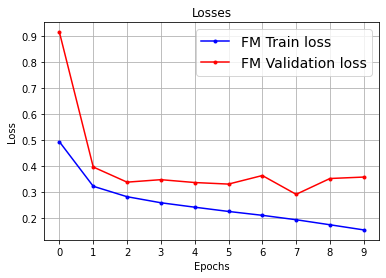

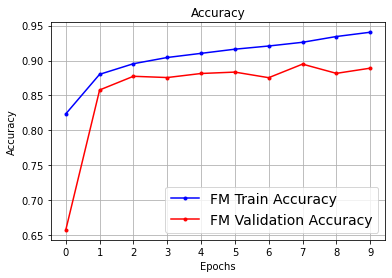

In [16]:
plot_learning_curves(resnet_fm.history["loss"], resnet_fm.history["val_loss"])
plt.show()
plot_learning_curves(resnet_fm.history["accuracy"], resnet_fm.history["val_accuracy"], y_label ="Accuracy", Title="Accuracy",
                         train_label = "FM Train Accuracy", val_label = "FM Validation Accuracy")

In [17]:
# Evaluation

resnet_eval_fm = res_model.evaluate(X_test_fm, y_test_fm)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (resnet_eval_fm[0], resnet_eval_fm[1]))

313/313 [==============================] - 5s 17ms/step - loss: 0.3913 - accuracy: 0.8784
Summary: Loss over the test dataset: 0.39, Accuracy: 0.88


##### Fitting ResNet Model on CIFAR-10

In [18]:
res_model = resnet(X_train_c10, 10)
res_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 16, 16, 64)        9408      
_________________________________________________________________
batch_normalization_36 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
residual_unit_16 (ResidualUn (None, 8, 8, 64)          74240     
_________________________________________________________________
residual_unit_17 (ResidualUn (None, 8, 8, 64)          74240     
_________________________________________________________________
residual_unit_18 (ResidualUn (None, 8, 8, 64)         

In [19]:
res_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [20]:
# Fitting the model

start = time.time()
resnet_c10 = res_model.fit(X_train_c10, y_train_c10, epochs=10, validation_data=(X_valid_c10, y_valid_c10),
                                 batch_size = 128)
end = time.time()
print("Temps total d'execution = "+str(end-start) +" "+ "s")

Epoch 1/10
352/352 [==============================] - 29s 74ms/step - loss: 1.9812 - accuracy: 0.3441 - val_loss: 2.9668 - val_accuracy: 0.1602
Epoch 2/10
352/352 [==============================] - 25s 71ms/step - loss: 1.2664 - accuracy: 0.5427 - val_loss: 1.4915 - val_accuracy: 0.4922
Epoch 3/10
352/352 [==============================] - 26s 74ms/step - loss: 1.0810 - accuracy: 0.6126 - val_loss: 1.4130 - val_accuracy: 0.5230
Epoch 4/10
352/352 [==============================] - 25s 72ms/step - loss: 0.9599 - accuracy: 0.6597 - val_loss: 1.2897 - val_accuracy: 0.5510
Epoch 5/10
352/352 [==============================] - 25s 70ms/step - loss: 0.8674 - accuracy: 0.6946 - val_loss: 1.1846 - val_accuracy: 0.5914
Epoch 6/10
352/352 [==============================] - 25s 70ms/step - loss: 0.7812 - accuracy: 0.7235 - val_loss: 1.5264 - val_accuracy: 0.5076
Epoch 7/10
352/352 [==============================] - 25s 71ms/step - loss: 0.6975 - accuracy: 0.7531 - val_loss: 1.2879 - val_accuracy:

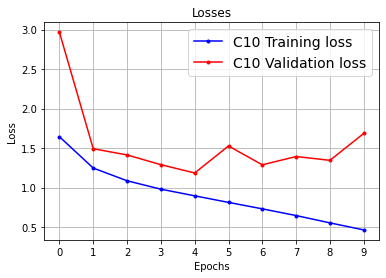

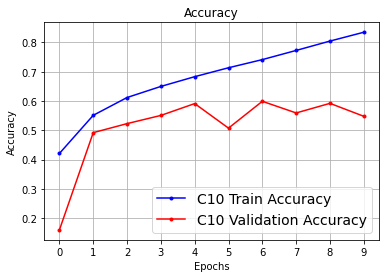

In [21]:
# Plotting Training loss vs Validation loss

plot_learning_curves(resnet_c10.history["loss"], resnet_c10.history["val_loss"], train_label = "C10 Training loss", 
                     val_label = "C10 Validation loss")
plt.show()
plot_learning_curves(resnet_c10.history["accuracy"], resnet_c10.history["val_accuracy"], y_label ="Accuracy", Title="Accuracy",
                         train_label = "C10 Train Accuracy", val_label = "C10 Validation Accuracy")

In [22]:
# Evaluation

resnet_eval_c10 = res_model.evaluate(X_test_c10, y_test_c10)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (resnet_eval_c10[0], resnet_eval_c10[1]))

313/313 [==============================] - 5s 16ms/step - loss: 1.7157 - accuracy: 0.5379
Summary: Loss over the test dataset: 1.72, Accuracy: 0.54


##### Fitting ResNet Model on CIFAR-100

In [23]:
res_model = resnet(X_train_c100, 100)
res_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 16, 16, 64)        9408      
_________________________________________________________________
batch_normalization_72 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
residual_unit_32 (ResidualUn (None, 8, 8, 64)          74240     
_________________________________________________________________
residual_unit_33 (ResidualUn (None, 8, 8, 64)          74240     
_________________________________________________________________
residual_unit_34 (ResidualUn (None, 8, 8, 64)         

In [24]:
res_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [25]:
# Fitting the model

start = time.time()
resnet_c100 = res_model.fit(X_train_c100, y_train_c100, epochs=10, validation_data=(X_valid_c100, y_valid_c100),
                                 batch_size = 128)
end = time.time()
print("Temps total d'execution = "+str(end-start) +" "+ "s")

Epoch 1/10
352/352 [==============================] - 38s 100ms/step - loss: 4.3371 - accuracy: 0.0816 - val_loss: 4.8261 - val_accuracy: 0.0296
Epoch 2/10
352/352 [==============================] - 26s 73ms/step - loss: 3.2535 - accuracy: 0.2139 - val_loss: 3.6773 - val_accuracy: 0.1544
Epoch 3/10
352/352 [==============================] - 20s 58ms/step - loss: 2.9050 - accuracy: 0.2736 - val_loss: 3.5968 - val_accuracy: 0.1696
Epoch 4/10
352/352 [==============================] - 20s 57ms/step - loss: 2.6386 - accuracy: 0.3291 - val_loss: 5.3265 - val_accuracy: 0.0866
Epoch 5/10
352/352 [==============================] - 21s 59ms/step - loss: 2.4227 - accuracy: 0.3690 - val_loss: 3.4572 - val_accuracy: 0.2158
Epoch 6/10
352/352 [==============================] - 30s 84ms/step - loss: 2.1898 - accuracy: 0.4183 - val_loss: 3.2734 - val_accuracy: 0.2408
Epoch 7/10
352/352 [==============================] - 20s 57ms/step - loss: 1.9594 - accuracy: 0.4712 - val_loss: 3.4702 - val_accuracy

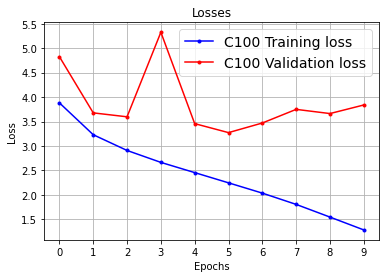

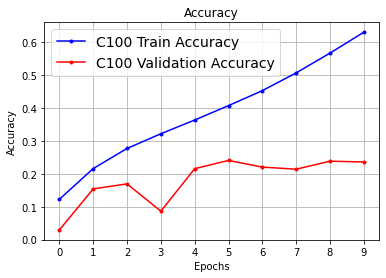

In [26]:
# Plotting Training loss vs Validation loss

plot_learning_curves(resnet_c100.history["loss"], resnet_c100.history["val_loss"], train_label = "C100 Training loss", 
                     val_label = "C100 Validation loss")
plt.show()
plot_learning_curves(resnet_c100.history["accuracy"], resnet_c100.history["val_accuracy"], y_label ="Accuracy", Title="Accuracy",
                         train_label = "C100 Train Accuracy", val_label = "C100 Validation Accuracy")

In [27]:
# Evaluation

resnet_eval_c100 = res_model.evaluate(X_test_c100, y_test_c100)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (resnet_eval_c100[0], resnet_eval_c100[1]))

313/313 [==============================] - 5s 17ms/step - loss: 3.7670 - accuracy: 0.2490
Summary: Loss over the test dataset: 3.77, Accuracy: 0.25


# Implementing Xception from scratch
### It is composed of 3 parts: Entry flow, Middle flow and Exit flow

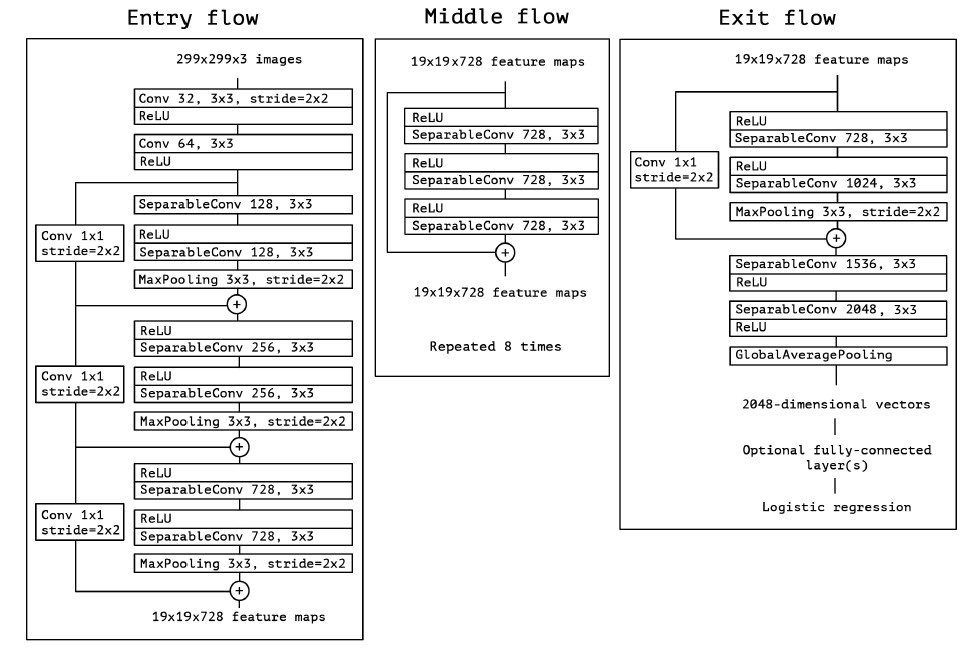

In [28]:
Image(filename='Xception.jpg')

In [29]:
### Building the Convolution Block ###

def conv_block(x, filters, block_num, conv_num, strides=(2,2)):
    
    name = 'block{}_conv{}_'.format(block_num, conv_num)

    # conv-BN-relu
    x = keras.layers.Conv2D(filters, (3,3), strides=(2,2), use_bias=False, 
                            name=name, kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = keras.layers.BatchNormalization(name=name+'bn')(x)
    x = keras.layers.Activation('relu', name=name+'act')(x)
    x = keras.layers.Dropout(rate=0.2)(x)

    return x

### Building the Separable Convolution Block ###

def separable_conv_block(x, filters, block_num, conv_num, pre_activation=None):
    name = 'block{}_sepconv{}_'.format(block_num, conv_num)

    if pre_activation is True:
        x = keras.layers.Activation('relu', name=name+'act')(x)
        x = keras.layers.Dropout(rate=0.2)(x)

    # (relu)-sepconv-BN-(relu)
    x = keras.layers.SeparableConv2D(filters, (3,3), padding='same', use_bias=False, 
                                     name=name, kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = keras.layers.BatchNormalization(name=name+'bn')(x)

    if pre_activation is False:
        x = keras.layers.Activation('relu', name=name+'act')(x)
        x = keras.layers.Dropout(rate=0.2)(x)

    return x

### Building the Middle Flow Block ###

def middle_flow_block(x, filters, block_num):

    residual = x

    x = separable_conv_block(x, filters, block_num=block_num, conv_num='1', pre_activation=True)
    x = separable_conv_block(x, filters, block_num=block_num, conv_num='2', pre_activation=True)
    x = separable_conv_block(x, filters, block_num=block_num, conv_num='3', pre_activation=True)

    return keras.layers.add([x, residual])

### building Xception Block ###

def xception_block(x, filters, block_num, pre_activation=True):
    
    block = 'block{}_'.format(block_num)
    filter_conv1, filter_conv2 = filters

    # residual conv branch
    residual = keras.layers.Conv2D(filter_conv2, (1, 1), strides=(2, 2),padding='same', 
                                   use_bias=False, kernel_regularizer=keras.regularizers.l2(0.01))(x)
    residual = keras.layers.BatchNormalization()(residual)

    # separable conv block
    x = separable_conv_block(x, filter_conv1, block_num=block_num, conv_num='1', pre_activation=pre_activation)
    x = separable_conv_block(x, filter_conv2, block_num=block_num, conv_num='2', pre_activation=True)

    # downsampling and merging
    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name=block+'pool')(x)

    return keras.layers.add([x, residual])


In [30]:
### Full Xception Model with the 3 parts (Entry flow, Middle flow and Exit flow)

def Xception(input_shape=(28,28,1), classes=10):
    
    np.random.seed(55)
    tf.random.set_seed(55)

    img_input = keras.layers.Input(shape=input_shape)

    #===========ENTRY FLOW==============
    # Module 1
    x = conv_block(img_input, 32, block_num='1', conv_num='1', strides=(2,2))
    x = conv_block(x, 64, block_num='1', conv_num='2')

    # Module 2
    x = xception_block(x, (128, 128), '2', pre_activation=False)

    # Module 3
    x = xception_block(x, (256, 256), '3')

    # Module 4
    x = xception_block(x, (728, 728), '4')


    #===========MIDDLE FLOW===============
    for i in range(8):
        block_num = str(5+i)
        x = middle_flow_block(x, 728, block_num)

    #========EXIT FLOW============
    # Module 13
    x = xception_block(x, (728, 1024), '13')

    # Module 14
    x = separable_conv_block(x, 1536, block_num='14', conv_num='1', pre_activation=False)
    x = separable_conv_block(x, 2048, block_num='14', conv_num='2', pre_activation=False)

    # logistic regression
    x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = keras.layers.Dense(classes, activation='softmax', name='predictions')(x)

    # Create model.
    model = keras.models.Model(inputs=img_input, outputs=x, name='xception')
    
    return model

##### Fitting Xception Model on Fashion MNIST

In [31]:
Xception_model = Xception()
Xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
block1_conv1_ (Conv2D)          (None, 13, 13, 32)   288         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 13, 13, 32)   128         block1_conv1_[0][0]              
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 13, 13, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [32]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)
Xception_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [33]:
# Fitting the model

start = time.time()
xception_fm = Xception_model.fit(X_train_fm, y_train_fm, epochs=10, validation_data=(X_valid_fm, y_valid_fm),
                                 batch_size = 128)
end = time.time()
print("Temps total d'execution = "+str(end-start) +" "+ "s")

Epoch 1/10
430/430 [==============================] - 38s 75ms/step - loss: 6.6817 - accuracy: 0.6577 - val_loss: 3.1640 - val_accuracy: 0.1256
Epoch 2/10
430/430 [==============================] - 32s 75ms/step - loss: 1.2182 - accuracy: 0.7958 - val_loss: 0.8263 - val_accuracy: 0.8186
Epoch 3/10
430/430 [==============================] - 27s 64ms/step - loss: 0.7701 - accuracy: 0.8223 - val_loss: 0.6196 - val_accuracy: 0.8538
Epoch 4/10
430/430 [==============================] - 24s 56ms/step - loss: 0.6177 - accuracy: 0.8404 - val_loss: 0.6946 - val_accuracy: 0.8204
Epoch 5/10
430/430 [==============================] - 23s 53ms/step - loss: 0.5375 - accuracy: 0.8501 - val_loss: 0.4723 - val_accuracy: 0.8706
Epoch 6/10
430/430 [==============================] - 23s 54ms/step - loss: 0.4928 - accuracy: 0.8583 - val_loss: 0.4637 - val_accuracy: 0.8670
Epoch 7/10
430/430 [==============================] - 23s 53ms/step - loss: 0.4687 - accuracy: 0.8602 - val_loss: 0.4013 - val_accuracy:

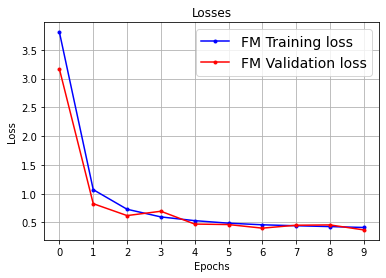

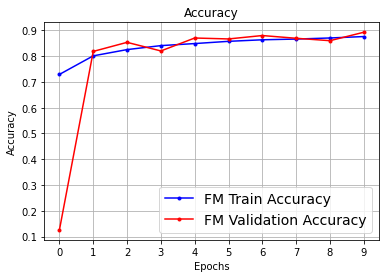

In [34]:
plot_learning_curves(xception_fm.history["loss"], xception_fm.history["val_loss"], train_label = "FM Training loss", 
                     val_label = "FM Validation loss")
plt.show()
plot_learning_curves(xception_fm.history["accuracy"], xception_fm.history["val_accuracy"], y_label ="Accuracy", Title="Accuracy",
                         train_label = "FM Train Accuracy", val_label = "FM Validation Accuracy")

In [35]:
# Evaluation

xception_eval_fm = Xception_model.evaluate(X_test_fm, y_test_fm)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (xception_eval_fm[0], xception_eval_fm[1]))

313/313 [==============================] - 6s 18ms/step - loss: 0.3950 - accuracy: 0.8861
Summary: Loss over the test dataset: 0.39, Accuracy: 0.89


##### Fitting Xception Model on CIFAR-10

In [36]:
Xception_model = Xception(input_shape=(32,32,3), classes=10)
Xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1_ (Conv2D)          (None, 15, 15, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 15, 15, 32)   128         block1_conv1_[0][0]              
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 15, 15, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [37]:
Xception_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [38]:
# Fitting the model

start = time.time()
xception_c10 = Xception_model.fit(X_train_c10, y_train_c10, epochs=10, validation_data=(X_valid_c10, y_valid_c10),
                                 batch_size = 128)
end = time.time()
print("Temps total d'execution = "+str(end-start) +" "+ "s")

Epoch 1/10
352/352 [==============================] - 31s 73ms/step - loss: 8.5722 - accuracy: 0.2819 - val_loss: 3.2212 - val_accuracy: 0.1182
Epoch 2/10
352/352 [==============================] - 20s 56ms/step - loss: 2.2752 - accuracy: 0.4285 - val_loss: 2.2711 - val_accuracy: 0.3168
Epoch 3/10
352/352 [==============================] - 23s 67ms/step - loss: 1.7728 - accuracy: 0.4810 - val_loss: 1.7069 - val_accuracy: 0.4744
Epoch 4/10
352/352 [==============================] - 23s 65ms/step - loss: 1.5810 - accuracy: 0.5096 - val_loss: 1.8315 - val_accuracy: 0.4408
Epoch 5/10
352/352 [==============================] - 26s 74ms/step - loss: 1.4681 - accuracy: 0.5345 - val_loss: 1.3754 - val_accuracy: 0.5616
Epoch 6/10
352/352 [==============================] - 25s 70ms/step - loss: 1.3882 - accuracy: 0.5574 - val_loss: 1.4261 - val_accuracy: 0.5414
Epoch 7/10
352/352 [==============================] - 22s 62ms/step - loss: 1.3322 - accuracy: 0.5753 - val_loss: 1.3645 - val_accuracy:

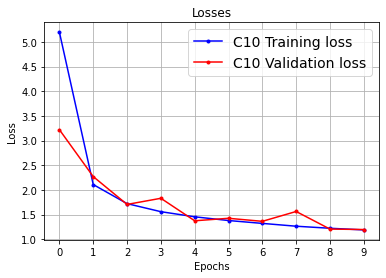

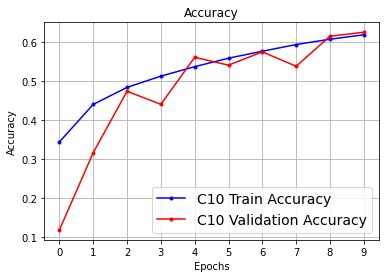

In [39]:
plot_learning_curves(xception_c10.history["loss"], xception_c10.history["val_loss"], train_label = "C10 Training loss", 
                     val_label = "C10 Validation loss")
plt.show()
plot_learning_curves(xception_c10.history["accuracy"], xception_c10.history["val_accuracy"], y_label ="Accuracy", Title="Accuracy",
                         train_label = "C10 Train Accuracy", val_label = "C10 Validation Accuracy")

In [40]:
# Evaluation

xception_eval_c10 = Xception_model.evaluate(X_test_c10, y_test_c10)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (xception_eval_c10[0], xception_eval_c10[1]))

313/313 [==============================] - 5s 17ms/step - loss: 1.2045 - accuracy: 0.6224
Summary: Loss over the test dataset: 1.20, Accuracy: 0.62


##### Fitting Xception Model on CIFAR-100

In [41]:
Xception_model = Xception(input_shape=(32,32,3), classes=100)
Xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1_ (Conv2D)          (None, 15, 15, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 15, 15, 32)   128         block1_conv1_[0][0]              
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 15, 15, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [42]:
Xception_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [43]:
# Fitting the model

start = time.time()
xception_c100 = Xception_model.fit(X_train_c100, y_train_c100, epochs=10, validation_data=(X_valid_c100, y_valid_c100),
                                 batch_size = 128)
end = time.time()
print("Temps total d'execution = "+str(end-start) +" "+ "s")

Epoch 1/10
352/352 [==============================] - 30s 71ms/step - loss: 10.4924 - accuracy: 0.0614 - val_loss: 5.3848 - val_accuracy: 0.0122
Epoch 2/10
352/352 [==============================] - 19s 55ms/step - loss: 4.2549 - accuracy: 0.1273 - val_loss: 4.3827 - val_accuracy: 0.0914
Epoch 3/10
352/352 [==============================] - 21s 59ms/step - loss: 3.7435 - accuracy: 0.1666 - val_loss: 4.1157 - val_accuracy: 0.1106
Epoch 4/10
352/352 [==============================] - 18s 53ms/step - loss: 3.5228 - accuracy: 0.1905 - val_loss: 3.9608 - val_accuracy: 0.1406
Epoch 5/10
352/352 [==============================] - 18s 52ms/step - loss: 3.3753 - accuracy: 0.2094 - val_loss: 3.8458 - val_accuracy: 0.1468
Epoch 6/10
352/352 [==============================] - 19s 54ms/step - loss: 3.2628 - accuracy: 0.2250 - val_loss: 3.7243 - val_accuracy: 0.1594
Epoch 7/10
352/352 [==============================] - 19s 55ms/step - loss: 3.1817 - accuracy: 0.2395 - val_loss: 3.4195 - val_accuracy

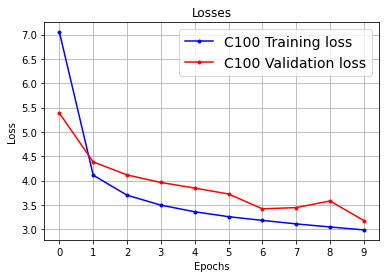

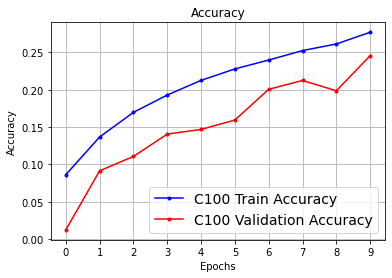

In [44]:
plot_learning_curves(xception_c100.history["loss"], xception_c100.history["val_loss"], train_label = "C100 Training loss", 
                     val_label = "C100 Validation loss")
plt.show()
plot_learning_curves(xception_c100.history["accuracy"], xception_c100.history["val_accuracy"], y_label ="Accuracy", Title="Accuracy",
                         train_label = "C100 Train Accuracy", val_label = "C100 Validation Accuracy")

In [45]:
# Evaluation

xception_eval_c100 = Xception_model.evaluate(X_test_c100, y_test_c100)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (xception_eval_c100[0], xception_eval_c100[1]))

313/313 [==============================] - 5s 16ms/step - loss: 3.1219 - accuracy: 0.2609
Summary: Loss over the test dataset: 3.12, Accuracy: 0.26


# Implementing Vision Transformer from scratch
### Interpret an image as a sequence of patches and process it by a standard Transformer encoder as used in NLP

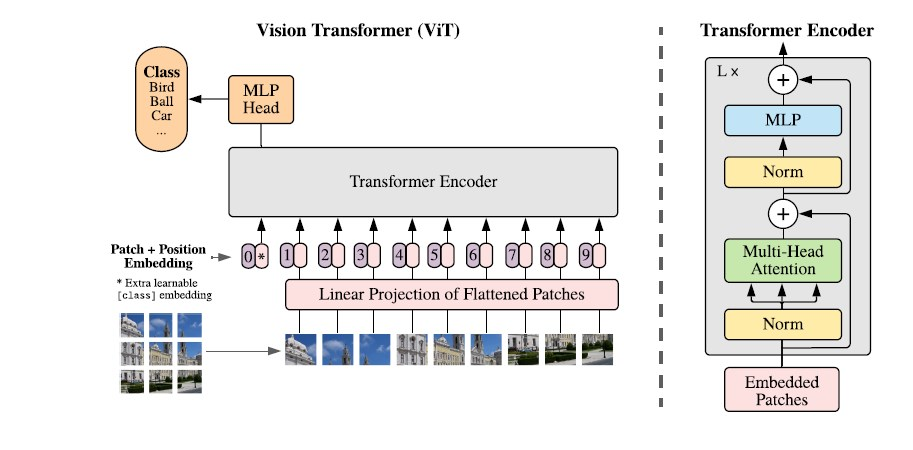

In [46]:
Image(filename='ViT.jpg')

In [47]:
# Implementing patch creation as a layer

class Patches(keras.layers.Layer):
    
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        
        return patches

# Implementing the patch encoding layer

class PatchEncoder(keras.layers.Layer):
    
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = keras.layers.Dense(units=projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        
        return encoded

# Implementing Multi Layer Perceptron

def mlp(x, hidden_units, dropout_rate):
    
    for units in hidden_units:
        x = keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        
    return x

In [48]:
# Implementing Vision Transformer

def vision_transformer(data, num_classes = 10,
                       patch_size = 6, projection_dim = 64, num_heads = 4, transformer_layers = 8):
    
    np.random.seed(555)
    tf.random.set_seed(555)
    
    img_size = data.shape[1]
    input_shape = data.shape[1:]
    num_patches = (img_size // patch_size) ** 2
    transformer_units = [projection_dim * 2, projection_dim, ]  # Size of the transformer layers
    mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
    
    inputs = keras.layers.Input(shape=input_shape)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        # Skip connection 1.
        x2 = keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = keras.layers.Add()([x3, x2])

    representation = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = keras.layers.Flatten()(representation)
    representation = keras.layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    output = keras.layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=output)
    
    return model

##### Fitting Vision Transformer Model on Fashion MNIST

In [49]:
vit_model = vision_transformer(X_train_fm)
vit_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
patches (Patches)               (None, None, 36)     0           input_4[0][0]                    
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 16, 64)       3392        patches[0][0]                    
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 16, 64)       128         patch_encoder[0][0]              
______________________________________________________________________________________________

In [50]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)
vit_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [51]:
# Fitting the model

start = time.time()
vit_fm = vit_model.fit(X_train_fm, y_train_fm, epochs=10, validation_data=(X_valid_fm, y_valid_fm),
                                 batch_size = 128)
end = time.time()
print("Temps total d'execution = "+str(end-start) +" "+ "s")

Epoch 1/10
430/430 [==============================] - 48s 93ms/step - loss: 1.1460 - accuracy: 0.6139 - val_loss: 0.5067 - val_accuracy: 0.8140
Epoch 2/10
430/430 [==============================] - 39s 91ms/step - loss: 0.5549 - accuracy: 0.7947 - val_loss: 0.4139 - val_accuracy: 0.8414
Epoch 3/10
430/430 [==============================] - 31s 72ms/step - loss: 0.4862 - accuracy: 0.8171 - val_loss: 0.3949 - val_accuracy: 0.8484
Epoch 4/10
430/430 [==============================] - 30s 71ms/step - loss: 0.4525 - accuracy: 0.8284 - val_loss: 0.3752 - val_accuracy: 0.8574
Epoch 5/10
430/430 [==============================] - 35s 82ms/step - loss: 0.4259 - accuracy: 0.8388 - val_loss: 0.3605 - val_accuracy: 0.8658
Epoch 6/10
430/430 [==============================] - 49s 113ms/step - loss: 0.4026 - accuracy: 0.8491 - val_loss: 0.3414 - val_accuracy: 0.8708
Epoch 7/10
430/430 [==============================] - 42s 99ms/step - loss: 0.3881 - accuracy: 0.8536 - val_loss: 0.3352 - val_accuracy

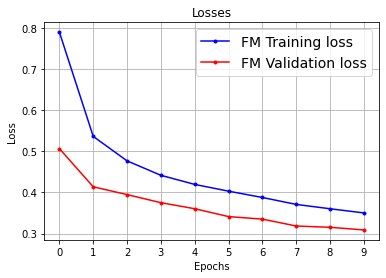

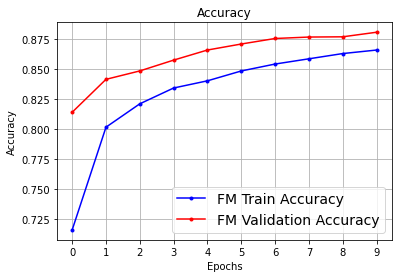

In [52]:
plot_learning_curves(vit_fm.history["loss"], vit_fm.history["val_loss"], train_label = "FM Training loss", 
                     val_label = "FM Validation loss")
plt.show()
plot_learning_curves(vit_fm.history["accuracy"], vit_fm.history["val_accuracy"], y_label ="Accuracy", Title="Accuracy",
                         train_label = "FM Train Accuracy", val_label = "FM Validation Accuracy")

In [53]:
# Evaluation

vit_eval_fm = vit_model.evaluate(X_test_fm, y_test_fm)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (vit_eval_fm[0], vit_eval_fm[1]))

313/313 [==============================] - 10s 31ms/step - loss: 0.3400 - accuracy: 0.8714
Summary: Loss over the test dataset: 0.34, Accuracy: 0.87


##### Fitting Vision Transformer Model on CIFAR-10

In [54]:
vit_model = vision_transformer(X_train_c10)
vit_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
patches_1 (Patches)             (None, None, 108)    0           input_5[0][0]                    
__________________________________________________________________________________________________
patch_encoder_1 (PatchEncoder)  (None, 25, 64)       8576        patches_1[0][0]                  
__________________________________________________________________________________________________
layer_normalization_17 (LayerNo (None, 25, 64)       128         patch_encoder_1[0][0]            
____________________________________________________________________________________________

In [55]:
vit_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [56]:
# Fitting the model

start = time.time()
vit_c10 = vit_model.fit(X_train_c10, y_train_c10, epochs=10, validation_data=(X_valid_c10, y_valid_c10),
                                 batch_size = 128)
end = time.time()
print("Temps total d'execution = "+str(end-start) +" "+ "s")

Epoch 1/10
352/352 [==============================] - 39s 88ms/step - loss: 2.3882 - accuracy: 0.1796 - val_loss: 1.7257 - val_accuracy: 0.3590
Epoch 2/10
352/352 [==============================] - 27s 76ms/step - loss: 1.7993 - accuracy: 0.3418 - val_loss: 1.5035 - val_accuracy: 0.4566
Epoch 3/10
352/352 [==============================] - 33s 95ms/step - loss: 1.6222 - accuracy: 0.4078 - val_loss: 1.3853 - val_accuracy: 0.5020
Epoch 4/10
352/352 [==============================] - 28s 80ms/step - loss: 1.5142 - accuracy: 0.4468 - val_loss: 1.3712 - val_accuracy: 0.5102
Epoch 5/10
352/352 [==============================] - 32s 90ms/step - loss: 1.4469 - accuracy: 0.4792 - val_loss: 1.3243 - val_accuracy: 0.5310
Epoch 6/10
352/352 [==============================] - 29s 83ms/step - loss: 1.3778 - accuracy: 0.4976 - val_loss: 1.2660 - val_accuracy: 0.5546
Epoch 7/10
352/352 [==============================] - 35s 101ms/step - loss: 1.3380 - accuracy: 0.5142 - val_loss: 1.1903 - val_accuracy

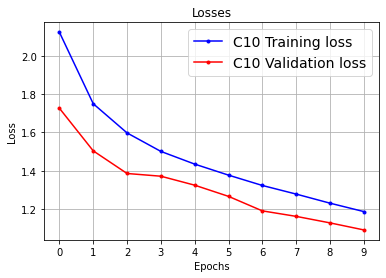

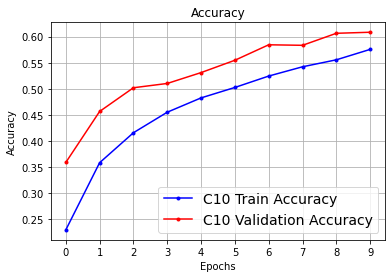

In [57]:
plot_learning_curves(vit_c10.history["loss"], vit_c10.history["val_loss"], train_label = "C10 Training loss", 
                     val_label = "C10 Validation loss")
plt.show()
plot_learning_curves(vit_c10.history["accuracy"], vit_c10.history["val_accuracy"], y_label ="Accuracy", Title="Accuracy",
                         train_label = "C10 Train Accuracy", val_label = "C10 Validation Accuracy")

In [58]:
# Evaluation

vit_eval_c10 = vit_model.evaluate(X_test_c10, y_test_c10)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (vit_eval_c10[0], vit_eval_c10[1]))

313/313 [==============================] - 9s 28ms/step - loss: 1.1356 - accuracy: 0.5898
Summary: Loss over the test dataset: 1.14, Accuracy: 0.59


##### Fitting Vision Transformer Model on CIFAR-100

In [59]:
vit_model = vision_transformer(X_train_c100, num_classes=100)
vit_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
patches_2 (Patches)             (None, None, 108)    0           input_6[0][0]                    
__________________________________________________________________________________________________
patch_encoder_2 (PatchEncoder)  (None, 25, 64)       8576        patches_2[0][0]                  
__________________________________________________________________________________________________
layer_normalization_34 (LayerNo (None, 25, 64)       128         patch_encoder_2[0][0]            
____________________________________________________________________________________________

In [60]:
vit_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [61]:
# Fitting the model

start = time.time()
vit_c100 = vit_model.fit(X_train_c100, y_train_c100, epochs=10, validation_data=(X_valid_c100, y_valid_c100),
                                 batch_size = 128)
end = time.time()
print("Temps total d'execution = "+str(end-start) +" "+ "s")

Epoch 1/10
352/352 [==============================] - 38s 81ms/step - loss: 4.8303 - accuracy: 0.0141 - val_loss: 4.3236 - val_accuracy: 0.0466
Epoch 2/10
352/352 [==============================] - 28s 80ms/step - loss: 4.3380 - accuracy: 0.0399 - val_loss: 3.9384 - val_accuracy: 0.0940
Epoch 3/10
352/352 [==============================] - 25s 72ms/step - loss: 4.0284 - accuracy: 0.0783 - val_loss: 3.8139 - val_accuracy: 0.1174
Epoch 4/10
352/352 [==============================] - 25s 72ms/step - loss: 3.8497 - accuracy: 0.1072 - val_loss: 3.5829 - val_accuracy: 0.1574
Epoch 5/10
352/352 [==============================] - 27s 77ms/step - loss: 3.6782 - accuracy: 0.1365 - val_loss: 3.3836 - val_accuracy: 0.1862
Epoch 6/10
352/352 [==============================] - 37s 106ms/step - loss: 3.5248 - accuracy: 0.1601 - val_loss: 3.2663 - val_accuracy: 0.2108
Epoch 7/10
352/352 [==============================] - 27s 75ms/step - loss: 3.3987 - accuracy: 0.1798 - val_loss: 3.1596 - val_accuracy

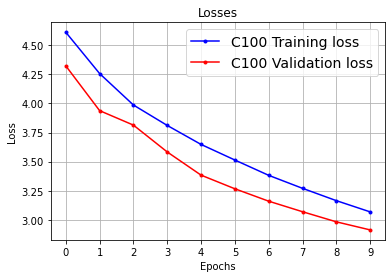

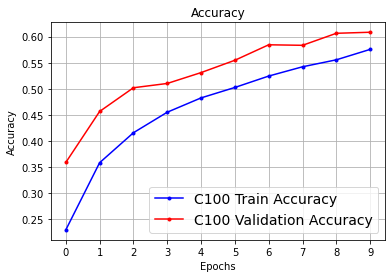

In [62]:
plot_learning_curves(vit_c100.history["loss"], vit_c100.history["val_loss"], train_label = "C100 Training loss", 
                     val_label = "C100 Validation loss")
plt.show()
plot_learning_curves(vit_c10.history["accuracy"], vit_c10.history["val_accuracy"], y_label ="Accuracy", Title="Accuracy",
                         train_label = "C100 Train Accuracy", val_label = "C100 Validation Accuracy")

In [63]:
# Evaluation

vit_eval_c100 = vit_model.evaluate(X_test_c100, y_test_c100)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (vit_eval_c100[0], vit_eval_c100[1]))

313/313 [==============================] - 8s 27ms/step - loss: 2.8946 - accuracy: 0.2820
Summary: Loss over the test dataset: 2.89, Accuracy: 0.28


# Recap and conclusion

### Fashion MNIST

In [75]:
# Plotting Results

def learning_curves(val1, val2, val3, y_label ="Accuracy", Title="Fashion MNIST",
                         val1_label = "ResNet", val2_label = "Xception", val3_label = "ViT"):
    
    plt.plot(np.arange(len(val1)), val1, "b.-", label=val1_label)
    plt.plot(np.arange(len(val2)), val2, "r.-", label=val2_label)
    plt.plot(np.arange(len(val3)), val3, "g.-", label=val3_label)
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=12)
    plt.xlabel("Epochs")
    plt.ylabel(y_label)
    plt.title(Title)
    plt.grid(True)

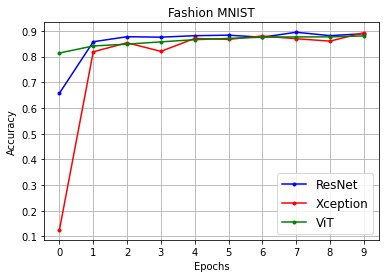

In [79]:
learning_curves(resnet_fm.history["val_accuracy"], xception_fm.history["val_accuracy"], vit_fm.history["val_accuracy"],
                Title="Fashion MNIST", val1_label = "ResNet", val2_label = "Xception", val3_label = "ViT")

### CIFAR-10

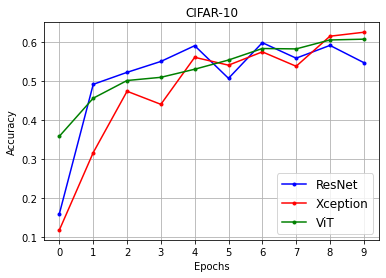

In [80]:
learning_curves(resnet_c10.history["val_accuracy"], xception_c10.history["val_accuracy"], vit_c10.history["val_accuracy"],
                Title="CIFAR-10", val1_label = "ResNet", val2_label = "Xception", val3_label = "ViT")

### CIFAR-100

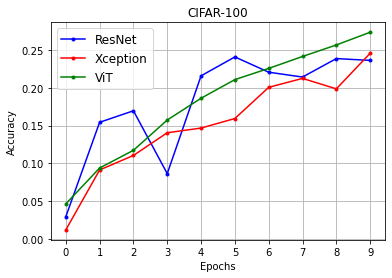

In [81]:
learning_curves(resnet_c100.history["val_accuracy"], xception_c100.history["val_accuracy"], vit_c100.history["val_accuracy"],
                Title="CIFAR-100", val1_label = "ResNet", val2_label = "Xception", val3_label = "ViT")

In [86]:
pd.read_excel("Recap.xlsx")

,Data,Modele,Final validation accuracy,Test accuracy,Number of epochs,Time for training,Total number of parameters,Batch size,Optimizer,Learning rate
0,Fashion MNIST,ResNet-34,0.8890,0.88,10,301 s,21300554,128,Adamax,0.001
1,Fashion MNIST,Xception,0.8930,0.89,10,~260 s,20881394,128,Adamax,0.001
2,Fashion MNIST,ViT,0.8806,0.87,10,384 s,4876746,128,Adamax,0.001
3,CIFAR-10,ResNet-34,0.5480,0.54,10,~256 s,21306826,128,Adamax,0.001
4,CIFAR-10,Xception,0.6260,0.62,10,~240 s,20881970,128,Adamax,0.001
5,CIFAR-10,ViT,0.6082,0.59,10,~314 s,6061578,128,Adamax,0.001
6,CIFAR-100,ResNet-34,0.2362,0.25,10,~251 s,21352996,128,Adamax,0.001
7,CIFAR-100,Xception,0.2456,0.26,10,~210 s,21066380,128,Adamax,0.001
8,CIFAR-100,ViT,0.2734,0.28,10,~300 s,6153828,128,Adamax,0.001


- Sur les donnees Fashion MNIST, la performance des 3 modeles est relativement pareille.
- Nous notons que le modele avec Vision Transformer a beaucoup moins de parametre que ceux de ResNet et Xception. Cependant, on obtient des resultats sensiblement similaires a ceux de Xception. Toutefois, les resultats de Vision Transformer sont nettement meilleurs a ceux de ResNet-34
- Il est aussi important de noter que Vision Transformer obtient le meilleur resultat sur les donnees CIFAR-100
- En ce qui concerne le temps d'entrainement, Xception enregistre le meilleur temps comparativement aux autres modeles